In [ ]:
!git clone https://github.com/ITMO-NSS-team/BAMT.git

In [1]:
import sys
sys.path.append('/content/BAMT')

In [ ]:
!pip install -r /content/BAMT/requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from visualization.visualization import draw_BN
from bayesian.sampling import generate_synthetics
from sklearn.model_selection import train_test_split
from bayesian.calculate_accuracy import calculate_acc
from scipy.stats import ks_2samp, ttest_ind, chisquare
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import discretization, get_nodes_sign, get_nodes_type
from bayesian.save_bn import save_structure, save_params, read_structure, read_params

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
lunar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/University/Multivariate/lunar_finale.csv',
                    index_col=0)

In [6]:
lunar['Saros Number'].value_counts()

 65     86
 47     86
 45     85
 27     85
 26     85
        ..
-18      6
-19      5
-20      3
 182     3
 183     2
Name: Saros Number, Length: 204, dtype: int64

In [7]:
lunar['Lunation Number'].value_counts()

-49456    1
-8281     1
-8322     1
-8316     1
-8310     1
         ..
-28874    1
-28869    1
-28863    1
-28857    1
 12378    1
Name: Lunation Number, Length: 12064, dtype: int64

In [8]:
lunar.columns

Index(['Delta T (s)', 'Lunation Number', 'Saros Number', 'Eclipse Type',
       'Quincena Solar Eclipse', 'Gamma', 'Penumbral Magnitude',
       'Umbral Magnitude', 'Penumbral Eclipse Duration (m)',
       'Partial Eclipse Duration (m)', 'Total Eclipse Duration (m)',
       'Latitude3', 'Longitude3', 'Time JD'],
      dtype='object')

In [9]:
saros_value_counts = lunar['Saros Number'].value_counts()
saros_probable = saros_value_counts.index[(saros_value_counts > 50) == True].to_list()

In [10]:
lunar_subset = lunar[lunar['Saros Number'].isin(saros_probable)]

In [11]:
lunar_subset = lunar_subset[['Saros Number', 'Eclipse Type',
                             'Quincena Solar Eclipse', 'Gamma', 'Penumbral Magnitude',
                             'Umbral Magnitude', 'Penumbral Eclipse Duration (m)', 'Partial Eclipse Duration (m)',
                             'Total Eclipse Duration (m)']]

In [12]:
lunar_train, lunar_test = train_test_split(lunar_subset, test_size=0.3)
lunar_target = ['Penumbral Magnitude', 'Umbral Magnitude', 'Saros Number', 'Penumbral Eclipse Duration (m)']

Correlation based structure

In [13]:
lunar_corr = lunar_train.corr()
lunar_corr

,Saros Number,Eclipse Type,Quincena Solar Eclipse,Gamma,Penumbral Magnitude,Umbral Magnitude,Penumbral Eclipse Duration (m),Partial Eclipse Duration (m),Total Eclipse Duration (m)
Saros Number,1.000000,-0.002676,0.046701,0.018166,-0.003639,-0.003927,0.004567,-0.002671,-0.013896
Eclipse Type,-0.002676,1.000000,0.190123,-0.015123,0.925469,0.925722,0.820756,0.931660,0.714410
Quincena Solar Eclipse,0.046701,0.190123,1.000000,-0.013379,0.228195,0.202736,0.235695,0.185010,0.276018
Gamma,0.018166,-0.015123,-0.013379,1.000000,-0.005537,-0.004774,-0.016391,-0.002785,0.000220
Penumbral Magnitude,-0.003639,0.925469,0.228195,-0.005537,1.000000,0.998274,0.903578,0.952520,0.791556
Umbral Magnitude,-0.003927,0.925722,0.202736,-0.004774,0.998274,1.000000,0.890657,0.950547,0.791419
Penumbral Eclipse Duration (m),0.004567,0.820756,0.235695,-0.016391,0.903578,0.890657,1.000000,0.855756,0.540178
Partial Eclipse Duration (m),-0.002671,0.931660,0.185010,-0.002785,0.952520,0.950547,0.855756,1.000000,0.680296
Total Eclipse Duration (m),-0.013896,0.714410,0.276018,0.000220,0.791556,0.791419,0.540178,0.680296,1.000000


In [14]:
lunar_corr[(lunar_corr < 0.5)] = ' '
lunar_corr

,Saros Number,Eclipse Type,Quincena Solar Eclipse,Gamma,Penumbral Magnitude,Umbral Magnitude,Penumbral Eclipse Duration (m),Partial Eclipse Duration (m),Total Eclipse Duration (m)
Saros Number,1.0,,,,,,,,
Eclipse Type,,1.0,,,0.925469,0.925722,0.820756,0.93166,0.71441
Quincena Solar Eclipse,,,1.0,,,,,,
Gamma,,,,1.0,,,,,
Penumbral Magnitude,,0.925469,,,1.0,0.998274,0.903578,0.95252,0.791556
Umbral Magnitude,,0.925722,,,0.998274,1.0,0.890657,0.950547,0.791419
Penumbral Eclipse Duration (m),,0.820756,,,0.903578,0.890657,1.0,0.855756,0.540178
Partial Eclipse Duration (m),,0.93166,,,0.95252,0.950547,0.855756,1.0,0.680296
Total Eclipse Duration (m),,0.71441,,,0.791556,0.791419,0.540178,0.680296,1.0


In [13]:
nodes_type = get_nodes_type(lunar_subset)
nodes_type

{'Saros Number': 'disc',
 'Eclipse Type': 'disc',
 'Quincena Solar Eclipse': 'disc',
 'Gamma': 'cont',
 'Penumbral Magnitude': 'cont',
 'Umbral Magnitude': 'cont',
 'Penumbral Eclipse Duration (m)': 'cont',
 'Partial Eclipse Duration (m)': 'cont',
 'Total Eclipse Duration (m)': 'cont'}

In [14]:
nodes_sign = get_nodes_sign(lunar_subset)
nodes_sign 

{'Gamma': 'neg',
 'Penumbral Magnitude': 'pos',
 'Umbral Magnitude': 'neg',
 'Penumbral Eclipse Duration (m)': 'pos',
 'Partial Eclipse Duration (m)': 'pos',
 'Total Eclipse Duration (m)': 'pos'}

In [15]:
discrete_data, coder = discretization(lunar_train, 'equal_frequency', list(nodes_sign.keys()))

In [113]:
bn = {'V': lunar_subset.columns.to_list(),
      'E': [['Penumbral Magnitude', 'Eclipse Type'],
            ['Umbral Magnitude', 'Eclipse Type'],
            ['Partial Eclipse Duration (m)', 'Eclipse Type'],
            ['Penumbral Eclipse Duration (m)', 'Eclipse Type'],
            ['Total Eclipse Duration (m)', 'Eclipse Type'],
            ['Umbral Magnitude', 'Penumbral Magnitude'],
            ['Penumbral Eclipse Duration (m)', 'Penumbral Magnitude'],
            ['Partial Eclipse Duration (m)', 'Penumbral Magnitude'],
            ['Total Eclipse Duration (m)', 'Penumbral Magnitude'],
            ['Penumbral Eclipse Duration (m)', 'Umbral Magnitude'],
            ['Partial Eclipse Duration (m)', 'Umbral Magnitude'],
            ['Total Eclipse Duration (m)', 'Umbral Magnitude'],
            ['Partial Eclipse Duration (m)', 'Penumbral Eclipse Duration (m)'],
            ['Total Eclipse Duration (m)', 'Penumbral Eclipse Duration (m)'],
            ['Total Eclipse Duration (m)', 'Partial Eclipse Duration (m)']]}

In [187]:
lunar_train['Eclipse Type'] = lunar_train['Eclipse Type'].astype('int32')
lunar_train['Saros Number'] = lunar_train['Saros Number'].astype('int32')
lunar_train['Quincena Solar Eclipse'] = lunar_train['Quincena Solar Eclipse'].astype('int32')
lunar_test['Eclipse Type'] = lunar_test['Eclipse Type'].astype('int32')
lunar_test['Saros Number'] = lunar_test['Saros Number'].astype('int32')
lunar_test['Quincena Solar Eclipse'] = lunar_test['Quincena Solar Eclipse'].astype('int32')
synth_df['Eclipse Type'] = synth_df['Eclipse Type'].astype('int32')
synth_df['Saros Number'] = synth_df['Saros Number'].astype('int32')
synth_df['Quincena Solar Eclipse'] = synth_df['Quincena Solar Eclipse'].astype('int32')

In [ ]:
draw_BN(bn, nodes_type, 'eslipse_bn_hc_k2')

In [118]:
params = parameter_learning(lunar_train, nodes_type, bn, 'simple')
save_structure(bn, 'bayes_structure_correlation')
skel = read_structure('bayes_structure_correlation')

In [119]:
save_params(params, 'bayes_params_correlation')
params = read_params('bayes_params_correlation')

In [25]:
bayes_correlation = HyBayesianNetwork(skel, params)

In [120]:
synth_df = generate_synthetics(bayes_correlation, nodes_sign, 'simple', lunar_train.shape[0])

<AxesSubplot:xlabel='Penumbral Magnitude', ylabel='Density'>

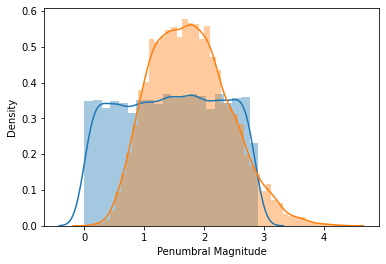

In [121]:
sns.distplot(lunar_train['Penumbral Magnitude'])
sns.distplot(synth_df['Penumbral Magnitude'])

In [24]:
def tests(original, synthesized, type_):
    if type_ == 'continuous':
        ks = ks_2samp(original, synthesized)
        print(ks)
    if type_ == 'discrete':
        original_values, original_counts = np.unique(original, return_counts=True)
        print(original_values)
        synthesized_values, synthesized_counts = np.unique(synthesized, return_counts=True)
        print(synthesized_values)
        cs = chisquare(synthesized_counts, original_counts)
        print(cs)

In [123]:
tests(lunar_train['Penumbral Magnitude'],
      synth_df['Penumbral Magnitude'],
      'continuous')

KstestResult(statistic=0.2294571544605388, pvalue=7.732972901897785e-171)


In [25]:
def create_qq_plots(original, synthesized):
    percs = np.linspace(0, 100, 31)
    qn_1 = np.percentile(original, percs)
    qn_2 = np.percentile(synthesized, percs)
    max = np.max([qn_1[~np.isnan(qn_1)], qn_2[~np.isnan(qn_2)]])
    min = np.min([qn_1[~np.isnan(qn_1)], qn_2[~np.isnan(qn_2)]])
    x = np.linspace(min, max)
    plt.plot(qn_1, qn_2, ls="", marker="o", markersize=6)
    plt.plot(x, x, color="k", ls="--")
    plt.xlim(min, max)
    plt.ylim(min, max)
    plt.xlabel('Original distribution')
    plt.ylabel('Synthesized distribution')
    plt.title('QQ plot of two samples')
    plt.show()

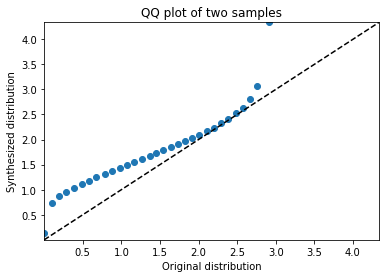

In [125]:
create_qq_plots(lunar_train['Penumbral Magnitude'], synth_df['Penumbral Magnitude'])

<AxesSubplot:xlabel='Umbral Magnitude', ylabel='Density'>

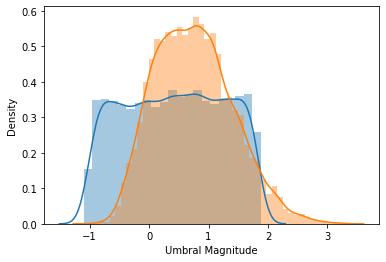

In [126]:
sns.distplot(lunar_train['Umbral Magnitude'])
sns.distplot(synth_df['Umbral Magnitude'])

In [127]:
tests(lunar_train['Umbral Magnitude'],
      synth_df['Umbral Magnitude'],
      'continuous')

KstestResult(statistic=0.23175849465276838, pvalue=2.6367309282530254e-174)


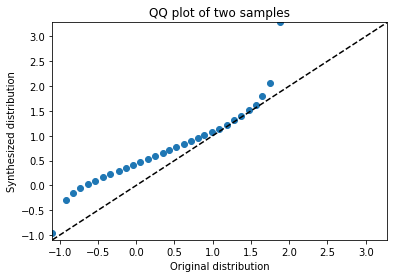

In [128]:
create_qq_plots(lunar_train['Umbral Magnitude'], synth_df['Umbral Magnitude'])

<AxesSubplot:xlabel='Saros Number', ylabel='Density'>

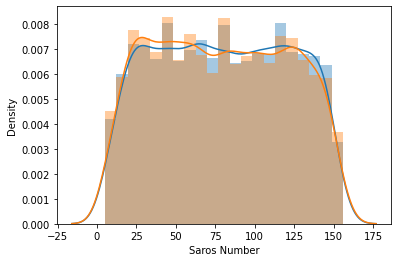

In [129]:
sns.distplot(lunar_train['Saros Number'])
sns.distplot(synth_df['Saros Number'])

In [132]:
tests(lunar_train['Saros Number'],
      synth_df['Saros Number'],
      'discrete')

[  5   6   7   8  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 156]
[  5   6   7   8  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 

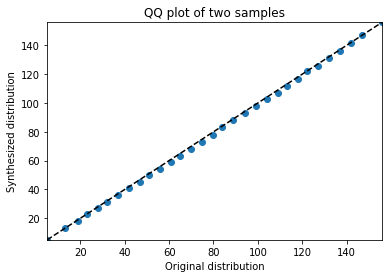

In [134]:
create_qq_plots(lunar_train['Saros Number'], synth_df['Saros Number'])

<AxesSubplot:xlabel='Penumbral Eclipse Duration (m)', ylabel='Density'>

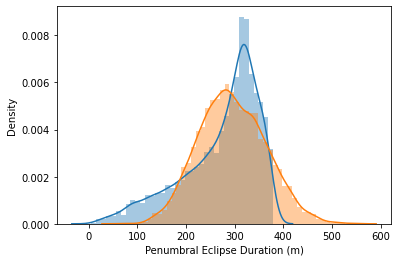

In [135]:
sns.distplot(lunar_train['Penumbral Eclipse Duration (m)'])
sns.distplot(synth_df['Penumbral Eclipse Duration (m)']) 

In [136]:
tests(lunar_train['Penumbral Eclipse Duration (m)'],
      synth_df['Penumbral Eclipse Duration (m)'],
      'continuous')

KstestResult(statistic=0.12021118180587519, pvalue=6.792374348348814e-47)


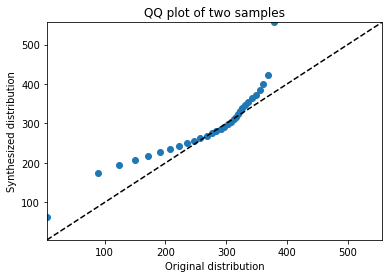

In [137]:
create_qq_plots(lunar_train['Penumbral Eclipse Duration (m)'], synth_df['Penumbral Eclipse Duration (m)'])

In [ ]:
accuracy = calculate_acc(bayes_correlation, lunar_test, lunar_target, 'simple')

In [ ]:
accuracy[:2]

({'Saros Number': 0.0},
 {'Penumbral Magnitude': 0.027,
  'Umbral Magnitude': 0.136,
  'Penumbral Eclipse Duration (m)': 40.755})

Hill-climbing + K2

In [138]:
bn = structure_learning(discrete_data, 'HC', nodes_type, 'K2')

In [139]:
bn

{'V': ['Saros Number',
  'Eclipse Type',
  'Quincena Solar Eclipse',
  'Gamma',
  'Penumbral Magnitude',
  'Umbral Magnitude',
  'Penumbral Eclipse Duration (m)',
  'Partial Eclipse Duration (m)',
  'Total Eclipse Duration (m)'],
 'E': [['Eclipse Type', 'Umbral Magnitude'],
  ['Eclipse Type', 'Quincena Solar Eclipse'],
  ['Eclipse Type', 'Saros Number'],
  ['Eclipse Type', 'Penumbral Magnitude'],
  ['Eclipse Type', 'Penumbral Eclipse Duration (m)'],
  ['Eclipse Type', 'Partial Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Saros Number'],
  ['Quincena Solar Eclipse', 'Penumbral Eclipse Duration (m)'],
  ['Gamma', 'Total Eclipse Duration (m)'],
  ['Penumbral Magnitude', 'Partial Eclipse Duration (m)'],
  ['Penumbral Magnitude', 'Gamma'],
  ['Penumbral Magnitude', 'Penumbral Eclipse Duration (m)'],
  ['Umbral Magnitude', 'Penumbral Magnitude'],
  ['Umbral Magnitude', 'Gamma'],
  ['Umbral Magnitude', 'Partial Eclipse Duration (m)'],
  ['Penumbral Eclipse Duration (m)', 'Partial Ecl

In [ ]:
draw_BN(bn, nodes_type, 'eslipse_bn_hc_k2')  

In [140]:
params = parameter_learning(lunar_train, nodes_type, bn, 'simple')
save_structure(bn, 'bayes_structure_hc_k2')
skel = read_structure('bayes_structure_hc_k2')

In [141]:
save_params(params, 'bayes_params_hc_k2')
params = read_params('bayes_params_hc_k2')

In [142]:
bayes_hc_k2 = HyBayesianNetwork(skel, params)

In [144]:
synth_df = generate_synthetics(bayes_hc_k2, nodes_sign, 'simple', lunar_train.shape[0])

<AxesSubplot:xlabel='Penumbral Magnitude', ylabel='Density'>

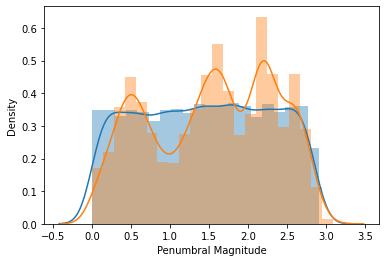

In [145]:
sns.distplot(lunar_train['Penumbral Magnitude'])
sns.distplot(synth_df['Penumbral Magnitude'])

In [146]:
tests(lunar_train['Penumbral Magnitude'],
      synth_df['Penumbral Magnitude'],
      'continuous')

KstestResult(statistic=0.08338973873020171, pvalue=9.284196464674701e-23)


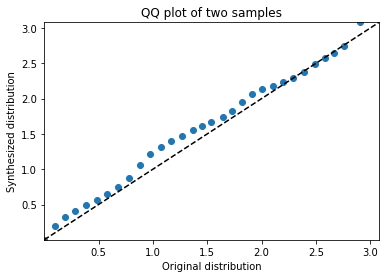

In [147]:
create_qq_plots(lunar_train['Penumbral Magnitude'], synth_df['Penumbral Magnitude'])

<AxesSubplot:xlabel='Umbral Magnitude', ylabel='Density'>

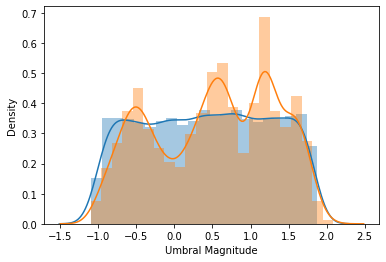

In [148]:
sns.distplot(lunar_train['Umbral Magnitude'])
sns.distplot(synth_df['Umbral Magnitude'])

In [149]:
tests(lunar_train['Umbral Magnitude'],
      synth_df['Umbral Magnitude'],
      'continuous')

KstestResult(statistic=0.08609719777988357, pvalue=3.105700945880741e-24)


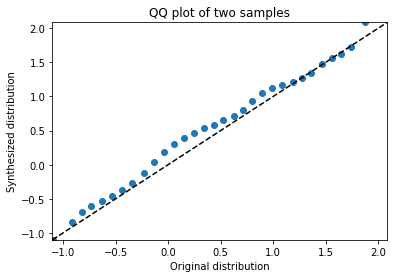

In [150]:
create_qq_plots(lunar_train['Umbral Magnitude'], synth_df['Umbral Magnitude'])

<AxesSubplot:xlabel='Saros Number', ylabel='Density'>

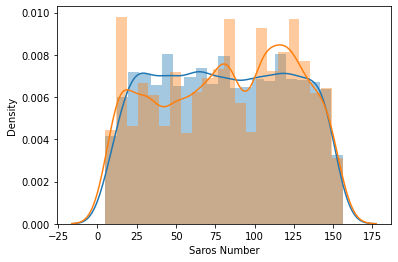

In [151]:
sns.distplot(lunar_train['Saros Number'])
sns.distplot(synth_df['Saros Number'])

In [155]:
tests(lunar_train['Saros Number'],
      synth_df['Saros Number'],
      'discrete')

[  5   6   7   8  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 156]
[  5   6   7   8  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 

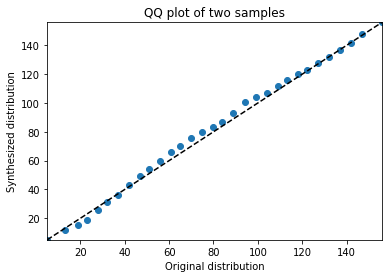

In [156]:
create_qq_plots(lunar_train['Saros Number'], synth_df['Saros Number'])

<AxesSubplot:xlabel='Penumbral Eclipse Duration (m)', ylabel='Density'>

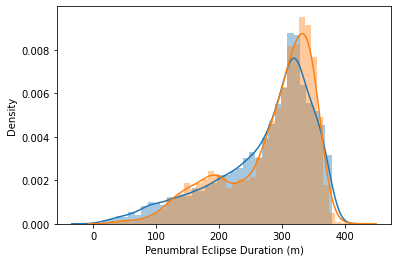

In [157]:
sns.distplot(lunar_train['Penumbral Eclipse Duration (m)'])
sns.distplot(synth_df['Penumbral Eclipse Duration (m)']) 

In [158]:
tests(lunar_train['Penumbral Eclipse Duration (m)'],
      synth_df['Penumbral Eclipse Duration (m)'],
      'continuous')

KstestResult(statistic=0.06741573033707865, pvalue=5.13299923272917e-15)


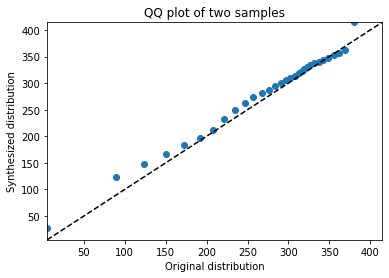

In [159]:
create_qq_plots(lunar_train['Penumbral Eclipse Duration (m)'], synth_df['Penumbral Eclipse Duration (m)'])

In [ ]:
accuracy = calculate_acc(bayes_hc_k2, lunar_test, lunar_target, 'simple')

In [ ]:
print(accuracy[:2])

({'Saros Number': 0.03}, {'Penumbral Magnitude': 0.172, 'Umbral Magnitude': 0.041, 'Penumbral Eclipse Duration (m)': 8.801})


Evo + MI

In [16]:
bn = structure_learning(discrete_data, 'evo', nodes_type, 'MI')

Best metric is 12.7796
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 12.7796
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.4 min
Best metric is 12.439900000000002
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.6 min
Best metric is 12.0435
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.7 min
Best metric is 11.809800000000001
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 0.9 min
Best metric is 11.722100000000001
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 1.1 min
Best metric is 11.722100000000001
Generation num: 6
max_depth: 6, no improvements: 1
spent time: 1.2 min
Best metric is 11.722000000000001
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 1.4 min
Best metric is 11.722000000000001
Generation num: 8
max_depth: 6, no improvements: 1
spent time: 1.6 min
Best metric is 11.5686
Generation num: 9
max_depth: 6, no improvements: 0
spent time: 1.

In [17]:
bn

{'V': ['Saros Number',
  'Eclipse Type',
  'Quincena Solar Eclipse',
  'Gamma',
  'Penumbral Magnitude',
  'Umbral Magnitude',
  'Penumbral Eclipse Duration (m)',
  'Partial Eclipse Duration (m)',
  'Total Eclipse Duration (m)'],
 'E': [['Umbral Magnitude', 'Penumbral Magnitude'],
  ['Total Eclipse Duration (m)', 'Penumbral Magnitude'],
  ['Total Eclipse Duration (m)', 'Umbral Magnitude'],
  ['Total Eclipse Duration (m)', 'Penumbral Eclipse Duration (m)'],
  ['Partial Eclipse Duration (m)', 'Umbral Magnitude'],
  ['Partial Eclipse Duration (m)', 'Total Eclipse Duration (m)'],
  ['Eclipse Type', 'Penumbral Eclipse Duration (m)'],
  ['Eclipse Type', 'Total Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Penumbral Magnitude'],
  ['Quincena Solar Eclipse', 'Umbral Magnitude'],
  ['Quincena Solar Eclipse', 'Penumbral Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Total Eclipse Duration (m)']]}

In [ ]:
draw_BN(bn, nodes_type, 'eslipse_bn_evo_mi')

In [18]:
params = parameter_learning(lunar_train, nodes_type, bn, 'simple')
save_structure(bn, 'bayes_structure_evo_mi')
skel = read_structure('bayes_structure_evo_mi')

In [19]:
save_params(params, 'bayes_params_evo_mi')
params = read_params('bayes_params_evo_mi')

In [20]:
bayes_evo_mi = HyBayesianNetwork(skel, params)

In [21]:
synth_df = generate_synthetics(bayes_evo_mi, nodes_sign, 'simple', lunar_train.shape[0])

<AxesSubplot:xlabel='Penumbral Magnitude', ylabel='Density'>

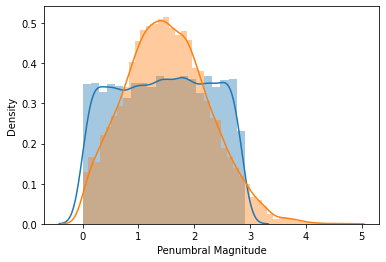

In [166]:
sns.distplot(lunar_train['Penumbral Magnitude'])
sns.distplot(synth_df['Penumbral Magnitude'])

In [167]:
tests(lunar_train['Penumbral Magnitude'],
      synth_df['Penumbral Magnitude'],
      'continuous')

KstestResult(statistic=0.09882225531338838, pvalue=8.353253096866451e-32)


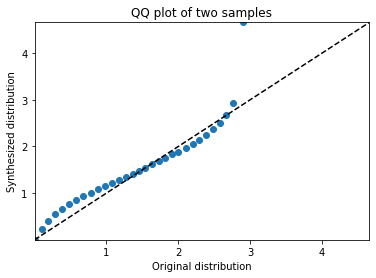

In [168]:
create_qq_plots(lunar_train['Penumbral Magnitude'], synth_df['Penumbral Magnitude'])

<AxesSubplot:xlabel='Umbral Magnitude', ylabel='Density'>

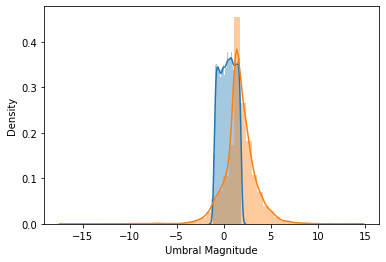

In [169]:
sns.distplot(lunar_train['Umbral Magnitude'])
sns.distplot(synth_df['Umbral Magnitude'])

In [170]:
tests(lunar_train['Umbral Magnitude'],
      synth_df['Umbral Magnitude'],
      'continuous')

KstestResult(statistic=0.6776770001353729, pvalue=0.0)


In [183]:
synth_df['Umbral Magnitude'].isnull().value_counts()

False    4010
True     3377
Name: Umbral Magnitude, dtype: int64

In [184]:
percs = np.linspace(0, 100, 31)
np.percentile(synth_df['Umbral Magnitude'], percs)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

<AxesSubplot:xlabel='Saros Number', ylabel='Density'>

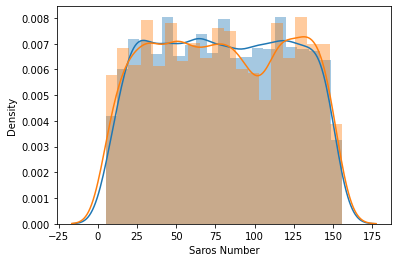

In [185]:
sns.distplot(lunar_train['Saros Number'])
sns.distplot(synth_df['Saros Number'])

In [188]:
tests(lunar_train['Saros Number'],
      synth_df['Saros Number'],
      'discrete')

[  5   6   7   8  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 156]
[  5   6   7   8  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 

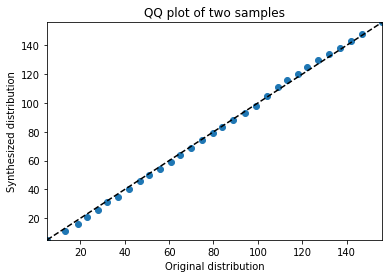

In [191]:
create_qq_plots(lunar_train['Saros Number'], synth_df['Saros Number'])

<AxesSubplot:xlabel='Penumbral Eclipse Duration (m)', ylabel='Density'>

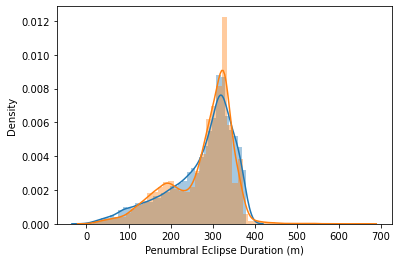

In [22]:
sns.distplot(lunar_train['Penumbral Eclipse Duration (m)'])
sns.distplot(synth_df['Penumbral Eclipse Duration (m)'])

In [26]:
tests(lunar_train['Penumbral Eclipse Duration (m)'],
      synth_df['Penumbral Eclipse Duration (m)'],
      'continuous')

KstestResult(statistic=0.05550291051847841, pvalue=2.592569023979477e-10)


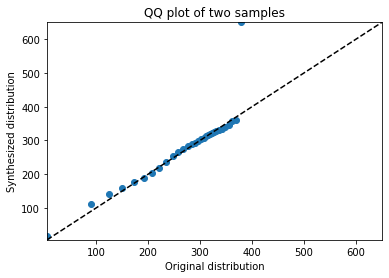

In [27]:
create_qq_plots(lunar_train['Penumbral Eclipse Duration (m)'],
                synth_df['Penumbral Eclipse Duration (m)'])

In [ ]:
accuracy = calculate_acc(bayes_evo_mi, lunar_test, lunar_target, 'simple')

In [ ]:
accuracy[:2] 

({'Saros Number': 0.01},
 {'Penumbral Magnitude': 0.167,
  'Umbral Magnitude': 0.838,
  'Penumbral Eclipse Duration (m)': 39.342})